In [1]:
import numpy as np
import numpy.random as rnd
import time
import os

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Все места, где нужно дописать код отмечены TODO.

## Считывание и подготовка данных.

In [2]:
# Считываем текстовые данные: все файлы должны лежать в одной папке data. 
# Проверьте, что у вас все хорошо с кодировками и текст нормально считывается.
data = ""

import codecs
for fname in os.listdir("data"):
    with codecs.open("data/"+fname, "r",encoding='cp1251', errors='ignore') as fin:
        text = fin.read()
        data += text

In [3]:
print(data[:200])

---------------------------------------------


 Гражданский Кодекс
 Российской Федерации.
 Часть первая



 №51-ФЗ 



30 ноября 1994 года

  Принят Государственной Думой 
  21 октябр


In [4]:
# Для дальнейшей работы нам нужно текст перевести в числовой формат.
chars = list(set(data))
VOCAB_SIZE = len(chars)

char_to_id = { ch:id for id,ch in enumerate(chars) }
id_to_char = { id:ch for id,ch in enumerate(chars) }
data_ids = [char_to_id[ch] for ch in data]

## Вспомогательные функции

In [5]:
# Необходимые константы
NUM_EPOCHS = 100
NUM_BATCHES = 1300
BATCH_SIZE = 100
SEQ_LEN = 20
LEARNING_RATE = 0.01
GRAD_CLIP = 100

В процессе обучения мы будем для каждого символа входной последовательности предсказывать следующий символ. Таким образом на вход сети мы будем подавать последовательности длины SEQ_LEN и получать на выходе последовательности той же длины, но со сдвигом на один символ.

In [6]:
def generate_random_batch(source):
    """Функция, которая генерирует batch из BATCH_SIZE случайных подстрок текста source. 
    Каждая подстрока должна иметь длину SEQ_LEN.
    
    source - массив целых чисел - номеров символов в тексте (пример - data_ids)
    
    Вернуть нужно кортеж (X,y), где
    X - матрица, в которой каждая строка - подстрока длины SEQ_LEN (подается на вход сети)
    y - матрица, в которой каждая строка - подстрока длины SEQ_LEN, (ожидается на выходе сети)
    Таким образом, каждая строка в y должна соответсвовать строке в X со сдвигом на один символ вправо.
    Например, если X[0]='hell', то y[0]='ello'
    
    Убедитесь, что вы генерируете X и y, которые правильно соответствуют друг другу.
    Также убедитесь, что ваша функция не вылезает за край текста (самое начало или конец текста).
    """
    
    len_source = len(source)
    ids = [rnd.randint(0, len_source - SEQ_LEN -  2)]
    X_batch = list(map(lambda t: source[t:t + SEQ_LEN], ids))
    y_batch = list(map(lambda t: source[t + 1:t + SEQ_LEN + 1], ids))
    
    return np.array(X_batch), np.array(y_batch)

In [7]:
a,b = generate_random_batch(data_ids)
print(''.join(id_to_char[id] for id in a[0,:]))
print(''.join(id_to_char[id] for id in b[0,:]))

надцати минимальных 
адцати минимальных р


В процессе тестирования мы будем предсказывать следующий символ по SEQ_LEN предыдущих. 
Генерировать очередной символ в тестовой посдедовательнсоти можно разными способами:
1. max_sample_fn: брать символ с максимальной вероятностью
2. proportional_sample_fn: генерировать символ пропорционально вероятности
3. alpha_sample_fn: генерировать символ пропорционально вероятности со следующей предобраоткой: 
    logprobs/alpha, где alpha - "жадность" из (0,1] - чем меньше, тем ближе генерация к выбору максимума
    после взятия экспоненты такие вероятности нужно перенормировать

Для устойчивости вычислений наша сеть будет выдавать не вероятности, а их логарифмы, поэтому не забывайте в нужных местах брать от них exp.

In [8]:
def max_sample_fn(logprobs):
    return np.argmax(logprobs) 

def proportional_sample_fn(logprobs):
    return rnd.choice([i for i in range(len(logprobs))], p=np.exp(logprobs))

def alpha_sample_fn(logprobs, alpha):
    p = np.exp(logprobs / alpha)
    p /= p.sum()
    return rnd.choice([i for i in range(len(logprobs))], p=p)

def generate_seed():
    """Функция выбирает случайное начало поседовательности из data, 
    которую мы потом можем продолжать с помощью нейросети.
    """
    start = np.random.randint(0,len(data)-SEQ_LEN)
    seed_phrase = data[start:start+SEQ_LEN]
    return seed_phrase

def generate_sample(logprobs_fn,sample_fn,seed_phrase,N=30):
    """Функция генерирует случайный текст при помощи нейросети и печатает его
    
    logprobs_fn - функция, которая по входной последовательности длины SEQ_LEN 
        предсказывает логарифмы вероятностей посдледующего символа (см. функцию train)
    sample_fn - функция, выбирающая следующий символ одним из способов, описанных выше
    seed_phrase - начальная фраза, с которой мы начинаем генерировать
    N - размер генерируемого текста
    
    """
    
    random_snippet = seed_phrase
    window = [char_to_id[ch] for ch in seed_phrase]
    for i in range(N):
        logprobs = np.squeeze(logprobs_fn(np.array(window)).data.cpu().numpy(), axis=0)
        ch = sample_fn(logprobs[-1, :])
        window.append(ch)
        window = window[1:]
        random_snippet += (id_to_char[ch])
    
    return random_snippet

In [9]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(err, network, logprobs_fn):
    return {'err':err, 
        'network':network,
        'logprobs_fn':logprobs_fn
           } 

# numerically stable log-softmax with crossentropy
def logsoftmax(x):
    xdev = x-x.max(2,keepdim=True)[0]
    lsm = xdev - torch.exp(xdev).sum(dim=2, keepdim=True).log()
    return lsm

def lsmCE(x,y):
    return -torch.clamp(x,-20,0).gather(2, y.unsqueeze(2)).squeeze().mean()

## Нейронная сеть

In [10]:
class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, SEQ_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое.
    3. Полносвязный слой n_hidden -> VOCAB_SIZE с logsoftmax в качестве нелинейности.
    
    В итоге на выход сеть должна возвращать ответ размера [BATCH_SIZE, SEQ_LEN, VOCAB_SIZE] 
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """

    
    def __init__(self, emb_size = 40, n_hidden = 100):
        super(Net, self).__init__()
        
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        
        self.emb        = nn.Embedding(VOCAB_SIZE, self.emb_size)
        self.rnn        = nn.RNN(self.emb_size, self.n_hidden, 2, batch_first=True)
        self.decode     = nn.Linear(self.n_hidden, VOCAB_SIZE)
        self.logsoftmax = logsoftmax

    def forward(self, text):
        emb            = self.emb(text)
        output, hidden = self.rnn(emb)
        decode         = self.decode(output)
        out            = self.logsoftmax(decode)
        return out

In [11]:
def train(data_ids, emb_size, n_hidden, show = False):
    """Функция обучает нейросеть по данным data_ids
    Следует обратить внимание на следующее:
    1. Сеть будем учить NUM_EPOCHS эпох, в каждой из которых будет NUM_BATCHES батчей
    2. Для того, чтобы следить за процессом обучения будем считать средний loss 
        на всех батчах в эпохе и сохранять его в массив err. Также будем генерировать 
        последовательности из случайных seeds после каждой эпохи, для этого нужна будет функция logprobs_fn,
        которая по входу х размера [1, SEQ_LEN] будет выдавать вектор логарифмов вероятностей 
        для последующего символа размера [1, VOCAB_SIZE]. 
        Например, если x='hell', то нас интересует каким будет символ после второго l. 
    3. Так как мы вместо softmax используем logsoftmax, то в качестве loss для сети нужно использовать lsmCE
    4. Перед тем, как делать шаг по градиенту, шрадиент нужно ограничивать по норме значением GRAD_CLIP
    
    * Если вы используете GPU, то не забудьте все данные и саму сеть перенести на GPU.
    """
    err = np.zeros(NUM_EPOCHS)

    print("Building network ...")
    net = Net(emb_size, n_hidden).cuda()
    net.train()
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    optimaizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    criterion  = lsmCE
        
    def logprobs_fn(snippetIdx):
        snippetIdx = snippetIdx[:, np.newaxis].T
        inp        = torch.from_numpy(snippetIdx).cuda()
        return net(Variable(inp))
        
    print("Training ...")
    for epoch in range(NUM_EPOCHS):
        
        start_time = time.time()
        loss       = 0
        
        for batch in range(NUM_BATCHES):
            data, target = generate_random_batch(data_ids)
            data, target = torch.from_numpy(data).cuda(), torch.from_numpy(target).cuda()
            data, target = Variable(data), Variable(target)
            output       = net(data)        
            loss        += criterion(output, target)
        
        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
        optimaizer.step()
        err[epoch] = loss.data[0] / NUM_BATCHES
        

        if show:
            seed = generate_seed()
            print("Seed: '{}'".format(seed))
            sample = generate_sample(logprobs_fn, max_sample_fn, seed)
            print("Max sample:", sample)
            smaple =generate_sample(logprobs_fn, proportional_sample_fn, seed)
            print("Proportional sample:", sample)
        print("Epoch {} \t loss = {:.4f} \t time = {:.2f}s".
                     format(epoch, err[epoch], time.time() - start_time))
             
    return pack(err, net, logprobs_fn)

Перед тем, как запускать обучение с большим числом итераций и длинными последовательностями, попробуйте запустить его на десяток итераций с последовательнсотямит по 5 символов и проверьте, что у вас генерируются какие-то вменяемые слоги. При этом достатояно использовать довольно маленькую сеть.

In [14]:
model = train(data_ids, 40, 300, show = False)

Building network ...
The network has 317982 params
Training ...
Epoch 0 	 loss = 4.6564 	 time = 5.06s
Epoch 1 	 loss = 4.0347 	 time = 4.46s
Epoch 2 	 loss = 3.3963 	 time = 4.44s
Epoch 3 	 loss = 3.8252 	 time = 4.43s
Epoch 4 	 loss = 3.6974 	 time = 4.53s
Epoch 5 	 loss = 3.6174 	 time = 4.43s
Epoch 6 	 loss = 3.4426 	 time = 4.77s
Epoch 7 	 loss = 3.3999 	 time = 4.46s
Epoch 8 	 loss = 3.3962 	 time = 4.39s
Epoch 9 	 loss = 3.4108 	 time = 4.63s
Epoch 10 	 loss = 3.3655 	 time = 4.40s
Epoch 11 	 loss = 3.3232 	 time = 4.74s
Epoch 12 	 loss = 3.2827 	 time = 4.55s
Epoch 13 	 loss = 3.2808 	 time = 4.43s
Epoch 14 	 loss = 3.2685 	 time = 4.76s
Epoch 15 	 loss = 3.2429 	 time = 4.82s
Epoch 16 	 loss = 3.2434 	 time = 4.74s
Epoch 17 	 loss = 3.2167 	 time = 4.74s
Epoch 18 	 loss = 3.1881 	 time = 4.78s
Epoch 19 	 loss = 3.1778 	 time = 4.53s
Epoch 20 	 loss = 3.1429 	 time = 4.48s
Epoch 21 	 loss = 3.0790 	 time = 4.74s
Epoch 22 	 loss = 3.0997 	 time = 4.49s
Epoch 23 	 loss = 3.0369 	

Epoch 201 	 loss = 1.6575 	 time = 4.61s
Epoch 202 	 loss = 1.6455 	 time = 4.80s
Epoch 203 	 loss = 1.6655 	 time = 4.50s
Epoch 204 	 loss = 1.6398 	 time = 4.43s
Epoch 205 	 loss = 1.6546 	 time = 4.60s
Epoch 206 	 loss = 1.6331 	 time = 4.46s
Epoch 207 	 loss = 1.6590 	 time = 4.81s
Epoch 208 	 loss = 1.6562 	 time = 4.35s
Epoch 209 	 loss = 1.6607 	 time = 4.76s
Epoch 210 	 loss = 1.6129 	 time = 4.42s
Epoch 211 	 loss = 1.6401 	 time = 4.65s
Epoch 212 	 loss = 1.6138 	 time = 4.44s
Epoch 213 	 loss = 1.6407 	 time = 4.39s
Epoch 214 	 loss = 1.6324 	 time = 4.72s
Epoch 215 	 loss = 1.6197 	 time = 4.56s
Epoch 216 	 loss = 1.6224 	 time = 4.73s
Epoch 217 	 loss = 1.6019 	 time = 4.42s
Epoch 218 	 loss = 1.6028 	 time = 4.63s
Epoch 219 	 loss = 1.6206 	 time = 4.62s
Epoch 220 	 loss = 1.6004 	 time = 4.38s
Epoch 221 	 loss = 1.5890 	 time = 4.65s
Epoch 222 	 loss = 1.6093 	 time = 4.36s
Epoch 223 	 loss = 1.6279 	 time = 4.68s
Epoch 224 	 loss = 1.6052 	 time = 4.33s
Epoch 225 	 loss

## Посмотрим что из этого вышло

In [16]:
seed = u"Каждый человек должен"
alpha = 0.5
sampling_fun = lambda x: alpha_sample_fn(x, alpha)
result_length = 300

generate_sample(model['logprobs_fn'],sampling_fun,seed,result_length)

'Каждый человек должен в размеров ремещения в том получающих законом пользования в порядке, подоставления по представления права общественных передальным переанием или действия иностративном порядки, контрольной право применение не принятеля правонарушения по определения настоящим Кодекса при на принятом постановление пр'

In [17]:
seed = u"В случае неповиновения"
alpha = 0.5
sampling_fun = lambda x: alpha_sample_fn(x, alpha)
result_length = 300

generate_sample(model['logprobs_fn'],sampling_fun,seed,result_length)

'В случае неповиновения сементом или из последствии области определение постановления по потреты собственность выборонного контракт в соответственных постановления по им при наследования представление обязательства или обосуществляющие совершении поставлении обосуществляется признанием статьи 109 настоящей статьи статьей '

## Дополнительные пункты

1. Обучение более сложной модели и контроль переобучения. Попробуйте подобрать хорошую модель RNN для данной задачи. Для этого  проанализируйте качество работы модели в зависимости от ее размеров, попробуйте использовать многослойную сеть. Также нужно проконтролировать переобучение моделей. Для этого можно выделить тестовый кусок из текста и смотреть на то, как меняется loss на нем в процессе обучения. Если на графиках видно переобучение, то стоит добавить dropout в модель (обычный dropout до, между и после рекуррентных слоев). 
2. LSTM и GRU архитектуры. Вместо обычной RNN попробуйте LSTM и GRU архитектуры и сравните получающиеся результаты для моделей нескольких разных размеров. Также сравните модели на данных с разной SEQ_LEN. 
4. Визуализация. Попробуйте провизуализировать результаты. Например, можно смотреть на то, какие буквы модель хорошо предсказывает, а в каких сильно не уверена. Это покажет что именно выучила модель лучше всего. Также можно попробовать смотреть на активации разных скрытых нейронов при прочтении текста (как у Андрея Карпатого).
5. Более сложные данные. Попробуйте обучить модель на более структурированных данных, например коде. Используйте LSTM и GRU сети, они хорошо улавливают структуру в данных. Проанализируйте результаты: выделите нейроны, активации которых "отвечают" за структуру в данных. Этот пункт, пожалуй, стоит пробовать только если у вас есть нормальный GPU.
6. Продвинутый дропаут. Запрограммировать RNN/LSTM с продвинутым дропаутом из (одним из 3, обсужденных на лекции). Сравнить с обычным вариантом дропаута по нерекуррентным связям.

In [24]:
class GRUNet(nn.Module):
    
    def __init__(self, emb_size = 40, n_hidden = 100, n_layers = 1):
        super(GRUNet, self).__init__()  
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(VOCAB_SIZE, self.emb_size)     
        self.gru = nn.GRU(input_size=self.emb_size, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)      
        self.decoder = nn.Linear(self.n_hidden, VOCAB_SIZE)
        self.logsoftmax = logsoftmax

    def forward(self, text):
        enc = self.encoder(text)
        output, h = self.gru(enc)
        dec = self.decoder(output)
        output = self.logsoftmax(dec)
        return output

In [39]:
class LSTMNet(nn.Module):
    def __init__(self, emb_size = 40, n_hidden = 100, n_layers = 1):
        super(LSTMNet, self).__init__()  
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(VOCAB_SIZE, self.emb_size)     
        self.lstm = nn.LSTM(input_size=self.emb_size, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)      
        self.decoder = nn.Linear(self.n_hidden, VOCAB_SIZE)
        self.logsoftmax = logsoftmax

    def forward(self, text):
        enc = self.encoder(text)
        output, (h, c) = self.lstm(enc)
        dec = self.decoder(output)
        output = self.logsoftmax(dec)
        return output

In [26]:
NUM_EPOCHS = 30
NUM_BATCHES = 1000
BATCH_SIZE = 100
SEQ_LEN = 20
LEARNING_RATE = 0.01
GRAD_CLIP = 100

In [43]:
def My_train(data_ids, emb_size, n_hidden, r_type, show = False):
    
    err=np.zeros(NUM_EPOCHS)

    print("Building network ...")

    if r_type == 'GRU':
        net = GRUNet(emb_size=emb_size, n_hidden=n_hidden)
    elif r_type == 'LSTM':
        net = LSTMNet(emb_size=emb_size, n_hidden=n_hidden)
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    net = net.cuda()
    net.train()
    
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
        
    def logprobs_fn(snippetIdx):
        snippetIdx = snippetIdx[:, np.newaxis].T
        inp        = torch.from_numpy(snippetIdx).cuda()
        return net(Variable(inp))
        
    print("Training ...")
    for epoch in range(NUM_EPOCHS):
        loss = 0
        start_time = time.time()
        for i in range(NUM_BATCHES):
            net.zero_grad()
            
            train_x, train_y = generate_random_batch(data_ids)
            train_x, train_y = torch.from_numpy(train_x).cuda(), torch.from_numpy(train_y).cuda()
            train_x, train_y = Variable(train_x), Variable(train_y)
            
            pred = net(train_x)
            err = lsmCE(pred, train_y)
            err.backward()
            nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
            optimizer.step()
            loss += err
        
        err[epoch] = loss.data[0] / NUM_BATCHES          

        if show:
            seed = generate_seed()
            print("Seed: '{}'".format(seed))
            sample = generate_sample(logprobs_fn, max_sample_fn, seed)
            print("Max sample:", sample)
            smaple =generate_sample(logprobs_fn, proportional_sample_fn, seed)
            print("Proportional sample:", sample)
        print("Epoch {} \t loss = {:.4f} \t time = {:.2f}s".
                     format(epoch, err[epoch], time.time() - start_time))
             
    return pack(err, net, logprobs_fn)

In [44]:
model_gru = My_train(data_ids, 40, 300, 'GRU', show = False)

Building network ...
The network has 342582 params
Training ...
Epoch 0 	 loss = 2.7144 	 time = 4.02s
Epoch 1 	 loss = 2.5556 	 time = 3.66s
Epoch 2 	 loss = 2.2615 	 time = 3.39s
Epoch 3 	 loss = 2.0869 	 time = 3.49s
Epoch 4 	 loss = 1.9847 	 time = 3.39s
Epoch 5 	 loss = 1.9142 	 time = 3.33s
Epoch 6 	 loss = 1.8682 	 time = 3.37s
Epoch 7 	 loss = 1.8701 	 time = 3.32s
Epoch 8 	 loss = 1.8499 	 time = 3.42s
Epoch 9 	 loss = 1.8275 	 time = 3.63s
Epoch 10 	 loss = 1.8515 	 time = 3.47s
Epoch 11 	 loss = 1.8378 	 time = 3.56s
Epoch 12 	 loss = 1.8139 	 time = 3.57s
Epoch 13 	 loss = 1.8371 	 time = 3.39s
Epoch 14 	 loss = 1.8303 	 time = 3.34s
Epoch 15 	 loss = 1.8352 	 time = 3.38s
Epoch 16 	 loss = 1.8321 	 time = 3.37s
Epoch 17 	 loss = 1.8635 	 time = 3.38s
Epoch 18 	 loss = 1.8044 	 time = 3.33s
Epoch 19 	 loss = 1.8231 	 time = 3.52s
Epoch 20 	 loss = 1.8317 	 time = 3.57s
Epoch 21 	 loss = 1.7911 	 time = 3.54s
Epoch 22 	 loss = 1.7844 	 time = 3.46s
Epoch 23 	 loss = 1.7971 	

In [45]:
model_lstm = My_train(data_ids, 40, 300, 'LSTM', show = False)

Building network ...
The network has 445182 params
Training ...
Epoch 0 	 loss = 2.3512 	 time = 3.79s
Epoch 1 	 loss = 1.9514 	 time = 3.76s
Epoch 2 	 loss = 1.6686 	 time = 3.70s
Epoch 3 	 loss = 1.5710 	 time = 3.62s
Epoch 4 	 loss = 1.4818 	 time = 3.50s
Epoch 5 	 loss = 1.4297 	 time = 3.50s
Epoch 6 	 loss = 1.4174 	 time = 3.48s
Epoch 7 	 loss = 1.4003 	 time = 3.52s
Epoch 8 	 loss = 1.4024 	 time = 3.67s
Epoch 9 	 loss = 1.3773 	 time = 3.65s
Epoch 10 	 loss = 1.3876 	 time = 3.59s
Epoch 11 	 loss = 1.3601 	 time = 3.69s
Epoch 12 	 loss = 1.4131 	 time = 3.49s
Epoch 13 	 loss = 1.3650 	 time = 3.64s
Epoch 14 	 loss = 1.3995 	 time = 3.83s
Epoch 15 	 loss = 1.3571 	 time = 3.59s
Epoch 16 	 loss = 1.3825 	 time = 3.58s
Epoch 17 	 loss = 1.3809 	 time = 3.70s
Epoch 18 	 loss = 1.3760 	 time = 3.70s
Epoch 19 	 loss = 1.3626 	 time = 3.52s
Epoch 20 	 loss = 1.3696 	 time = 3.50s
Epoch 21 	 loss = 1.3857 	 time = 3.67s
Epoch 22 	 loss = 1.3540 	 time = 3.73s
Epoch 23 	 loss = 1.3599 	

LSTM показывает лучшие результаты по сравнению с GRU при тех же параметрах. Посмотрим как влияет параметр SEQ_LEN на качество работы LSTM

In [47]:
models = dict()
for sl in range(10, 30, 5):
    SEQ_LEN = sl
    model = My_train(data_ids, 40, 300, 'LSTM', show = False)
    models[str(sl)] = model

Building network ...
The network has 445182 params
Training ...
Epoch 0 	 loss = 2.5613 	 time = 3.52s
Epoch 1 	 loss = 2.1876 	 time = 3.49s
Epoch 2 	 loss = 2.0037 	 time = 3.40s
Epoch 3 	 loss = 1.8644 	 time = 3.30s
Epoch 4 	 loss = 1.7406 	 time = 3.25s
Epoch 5 	 loss = 1.7604 	 time = 3.31s
Epoch 6 	 loss = 1.7134 	 time = 3.54s
Epoch 7 	 loss = 1.6678 	 time = 3.42s
Epoch 8 	 loss = 1.6977 	 time = 3.49s
Epoch 9 	 loss = 1.6652 	 time = 3.32s
Epoch 10 	 loss = 1.6594 	 time = 3.30s
Epoch 11 	 loss = 1.6523 	 time = 3.22s
Epoch 12 	 loss = 1.6851 	 time = 3.31s
Epoch 13 	 loss = 1.6862 	 time = 3.33s
Epoch 14 	 loss = 1.6776 	 time = 3.24s
Epoch 15 	 loss = 1.6811 	 time = 3.28s
Epoch 16 	 loss = 1.6857 	 time = 3.32s
Epoch 17 	 loss = 1.6517 	 time = 3.29s
Epoch 18 	 loss = 1.6404 	 time = 3.19s
Epoch 19 	 loss = 1.6102 	 time = 3.26s
Epoch 20 	 loss = 1.5999 	 time = 3.27s
Epoch 21 	 loss = 1.6202 	 time = 3.19s
Epoch 22 	 loss = 1.6117 	 time = 3.28s
Epoch 23 	 loss = 1.6448 	

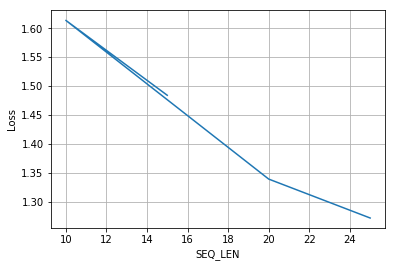

In [69]:
import matplotlib.pyplot as plt
pairs = [(int(k), models[k]['err'][-1]) for k in models.keys()]
plt.plot([p[0] for p in pairs], [p[1] for p in pairs])
plt.xlabel('SEQ_LEN')
plt.ylabel('Loss')
plt.grid()
plt.show()

Исходя из графика с увеличением параметра SEQ_LEN модель показывает лучшее качество